# Simulation analysis

This notebook analyzes the evolution of a single bunch.

In [1]:
import os
from pprint import pprint
import sys

from ipywidgets import interact
from ipywidgets import widgets
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
from scipy import interpolate
from tqdm.notebook import tqdm
from tqdm.notebook import trange

sys.path.append("/home/46h/repo/psdist/")
import psdist as ps
import psdist.visualization as psv

In [2]:
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["colorbar.width"] = "1.2em"
pplt.rc["cycle"] = "538"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

## Setup

In [3]:
save = False

In [4]:
timestamp = 230905102530
folder = f"../../data/sns_btf/sim/{timestamp}"
sorted(os.listdir(folder))

['bunch_0000_START.dat',
 'bunch_0001_MEBT:HZ33a.dat',
 'history.dat',
 'lattice_nodes.txt',
 'lattice_structure.txt',
 'log.txt',
 'losses.txt',
 'lostbunch.dat',
 'sim.py']

In [5]:
if save:
    outdir = f"../figures/{timestamp}/"
    if not os.path.isdir(outdir):
        os.makedirs(outdir)

def save_figure(filename):
    if not save:
        return
    filename = os.path.join(outdir, filename)
    plt.savefig(filename)

## Scalar history

Load node positions.

In [6]:
file = open(os.path.join(folder, f"lattice_nodes.txt"), "r")
nodes_dict = dict()
nodes_list = list()
last = offset = 0.0
for i, line in enumerate(file):
    if i == 0:
        continue
    name, position, length = line.rstrip().split()
    position = float(position)
    length = float(length)
    if position < last:
        offset = offset + last
    last = position
    position = position + offset
    nodes_dict[name] = [position, length]
    nodes_list.append([name, position, length])
file.close()

Load scalar history.

In [7]:
filename = os.path.join(folder, f"history.dat")
history = pd.read_csv(filename)
for index in range(history.shape[0]):
    Sigma = np.zeros((6, 6))
    for i in range(6):
        for j in range(i + 1):
            Sigma[i, j] = Sigma[j, i] = history.loc[index, f"cov_{j}-{i}"]
    history.loc[index, "eps_x"] = np.sqrt(np.linalg.det(Sigma[0:2, 0:2]))
    history.loc[index, "eps_y"] = np.sqrt(np.linalg.det(Sigma[2:4, 2:4]))
    history.loc[index, "eps_z"] = np.sqrt(np.linalg.det(Sigma[4:6, 4:6]))
    history.loc[index, "eps_xy"] = np.sqrt(np.linalg.det(Sigma[0:4, 0:4]))
    history.loc[index, "eps_xyz"] = np.sqrt(np.linalg.det(Sigma[:, :]))    
if ("mean_" in history.columns) and ("mean_3" not in history.columns):  # ?
    history.rename(columns={"mean_": "mean_3"}, inplace=True)
history["phi_max"] = -history["z_to_phase_coeff"] * history["z_max"]
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   y_rms             536 non-null    float64
 1   cov_1-1           536 non-null    float64
 2   energy            536 non-null    float64
 3   cov_1-3           536 non-null    float64
 4   cov_1-4           536 non-null    float64
 5   cov_3-3           536 non-null    float64
 6   n_parts           536 non-null    int64  
 7   z_rms             536 non-null    float64
 8   cov_3-4           536 non-null    float64
 9   cov_0-5           536 non-null    float64
 10  cov_4-5           536 non-null    float64
 11  cov_0-4           536 non-null    float64
 12  z_rms_deg         536 non-null    float64
 13  z_max             536 non-null    float64
 14  cov_1-5           536 non-null    float64
 15  cov_5-5           536 non-null    float64
 16  z_to_phase_coeff  536 non-null    float64
 1

### Energy 

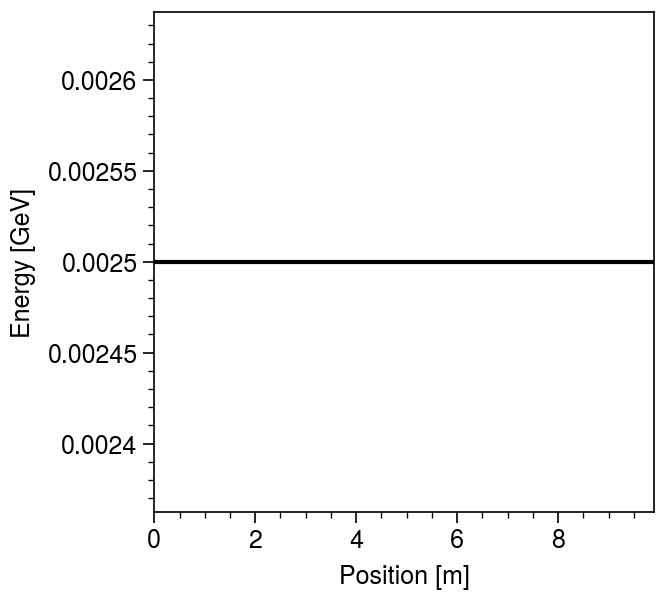

In [8]:
fig, ax = pplt.subplots()
ax.plot(history["position"], history["energy"], color="black")
ax.format(xlabel="Position [m]", ylabel="Energy [GeV]")
save_figure("energy")

### First-order moments 

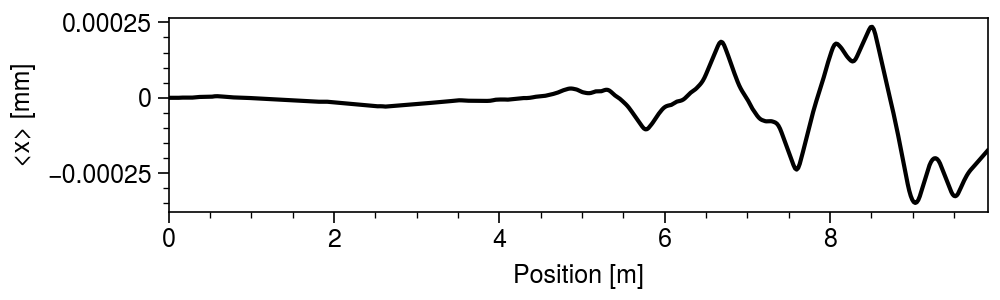

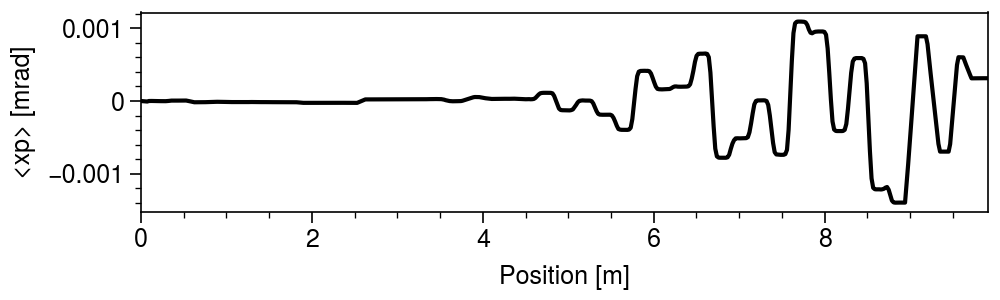

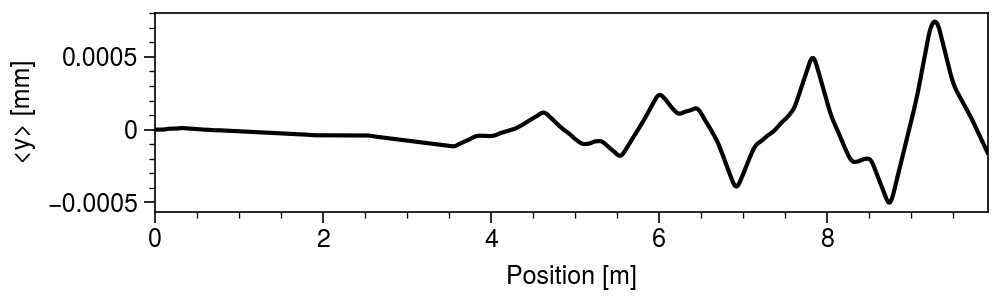

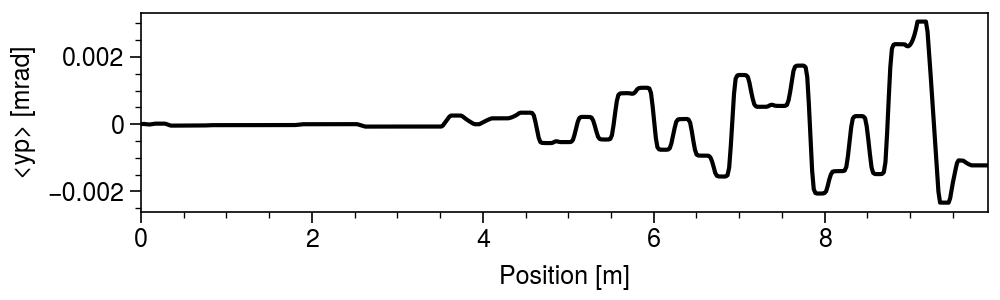

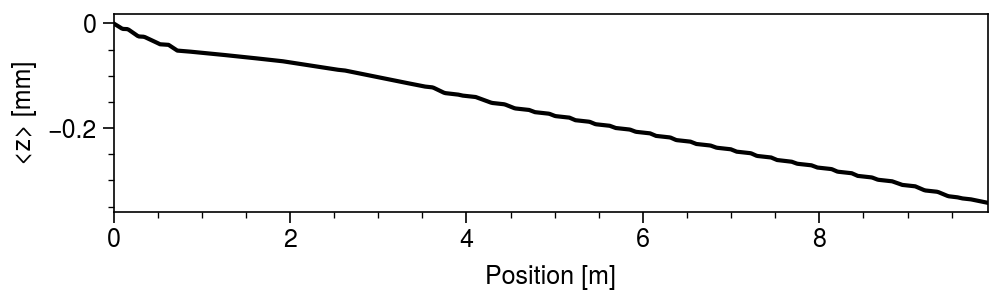

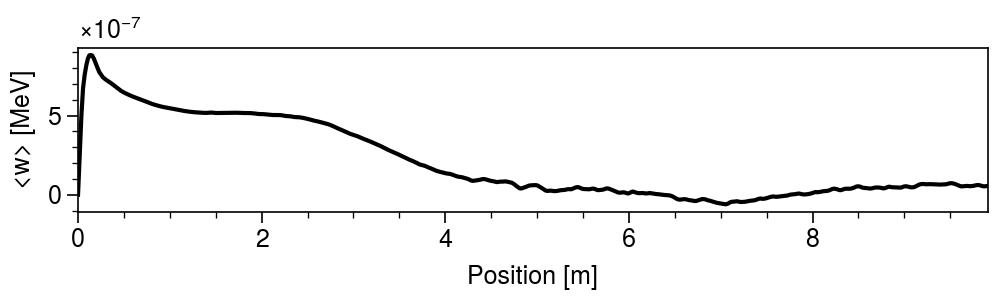

In [9]:
_dims = ["x", "xp", "y", "yp", "z", "w"]
_units = ["mm", "mrad", "mm", "mrad", "mm", "MeV"]
for i in range(6):
    fig, ax = pplt.subplots(figsize=(5.0, 1.5))
    ax.plot(
        history["position"],
        1000.0 * history[f"mean_{i}"],
        color="black",
    )
    ax.format(xlabel="Position [m]", ylabel=f"<{_dims[i]}> [{_units[i]}]")
    save_figure(f"mean_{i}")
    plt.show()

### Second-order moments

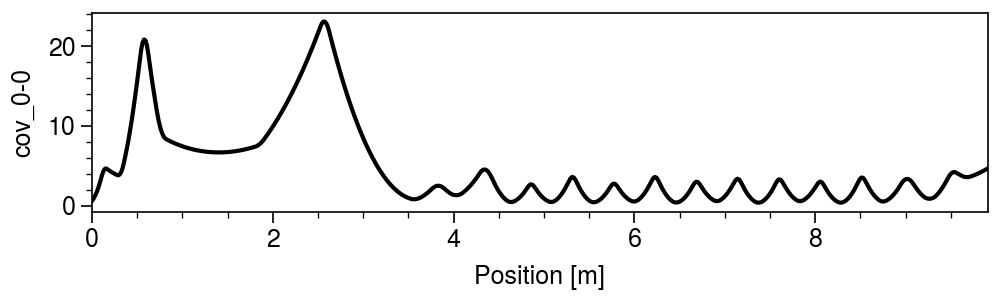

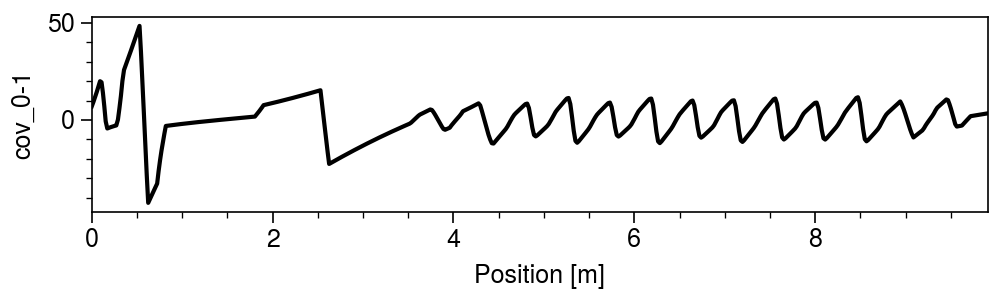

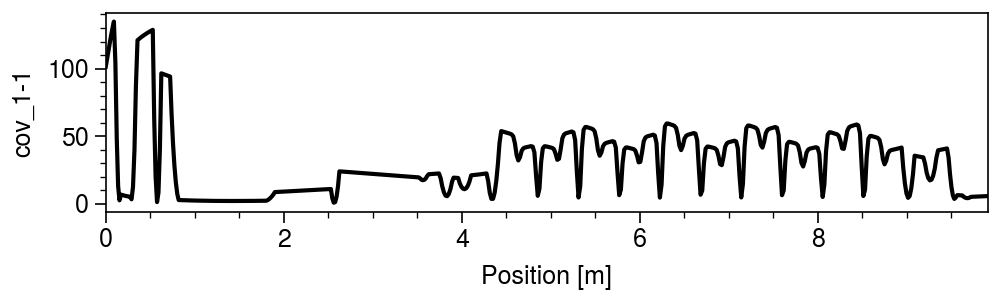

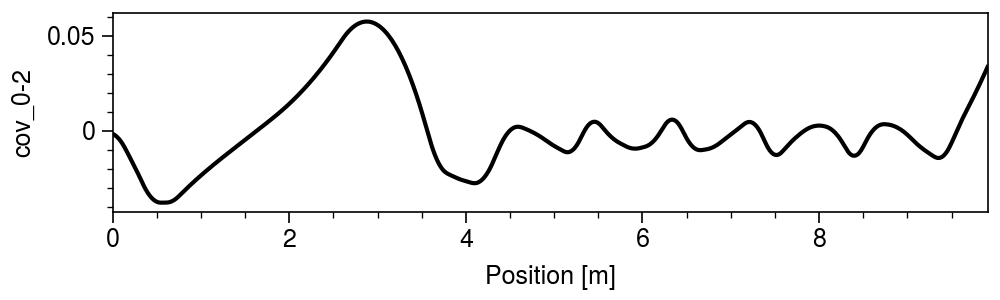

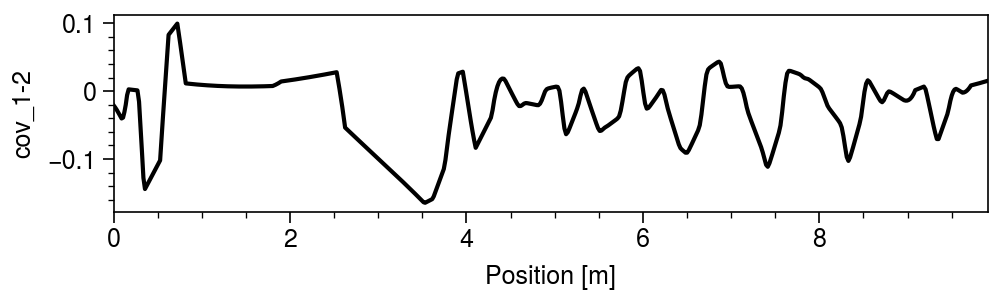

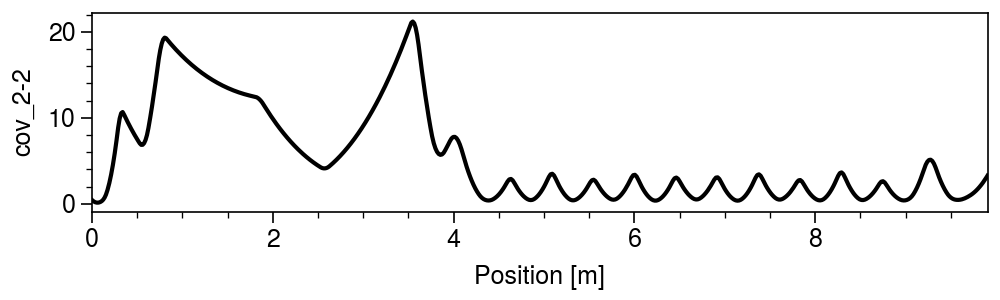

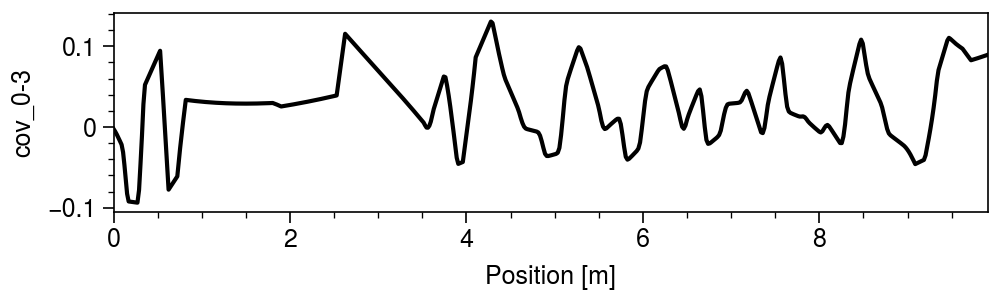

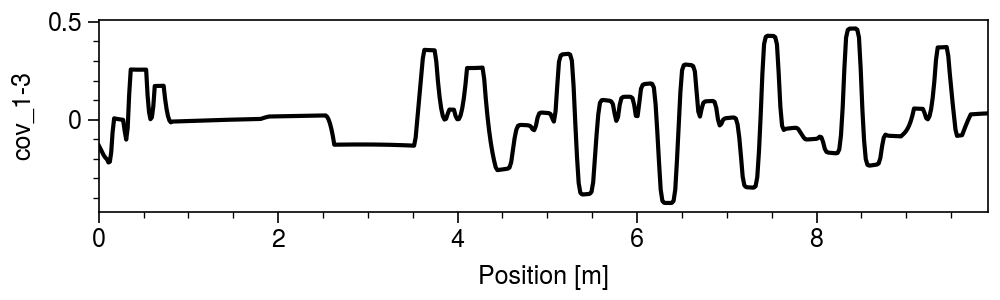

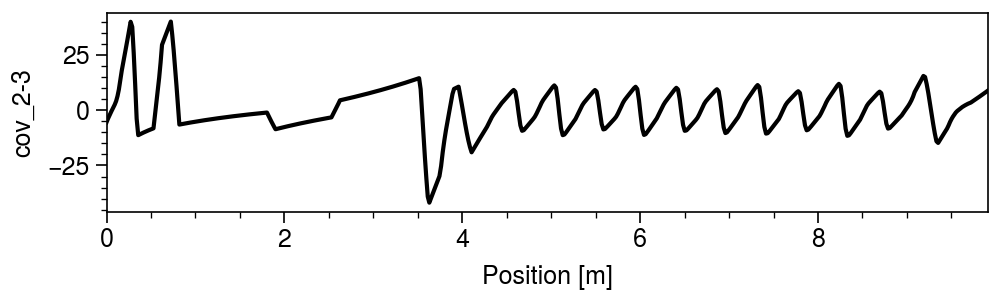

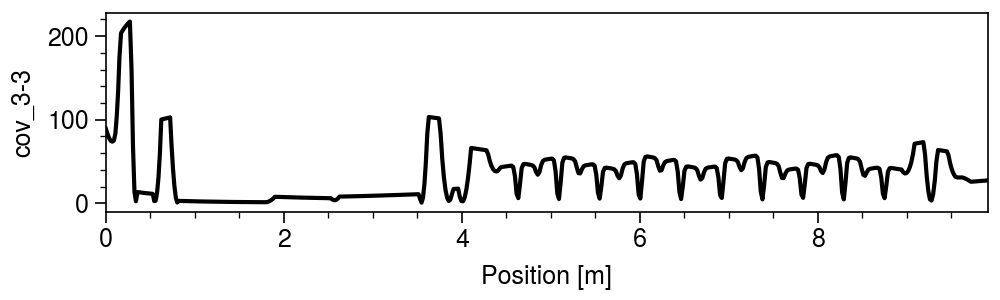

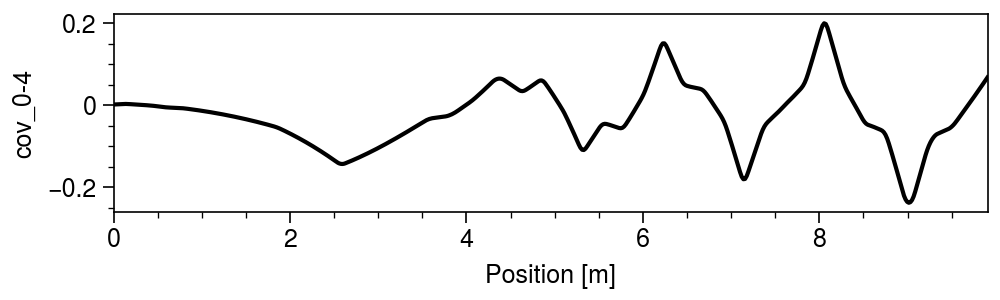

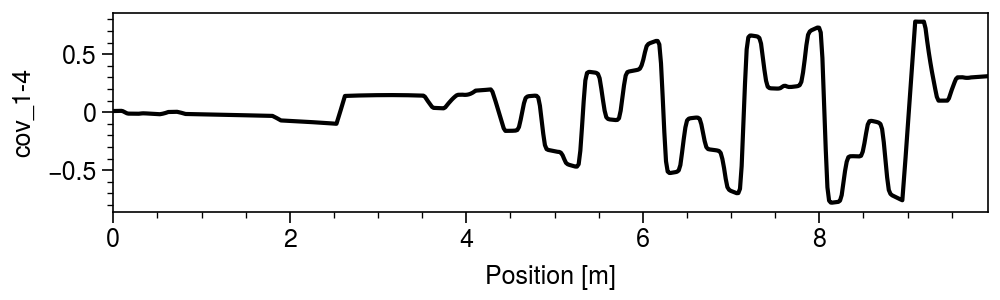

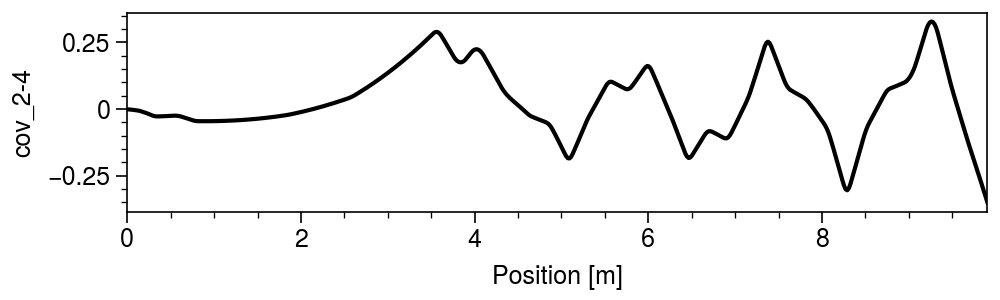

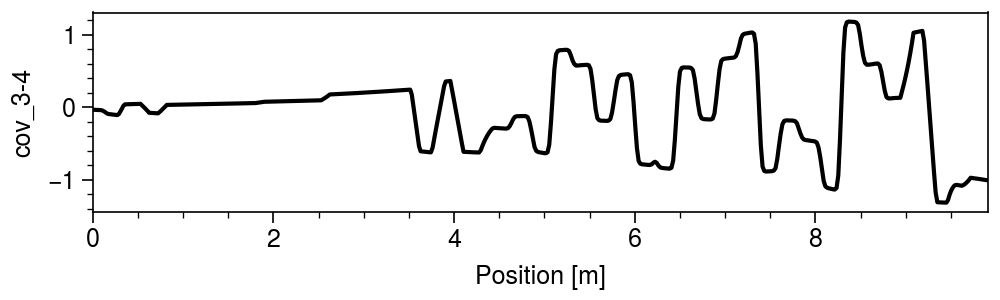

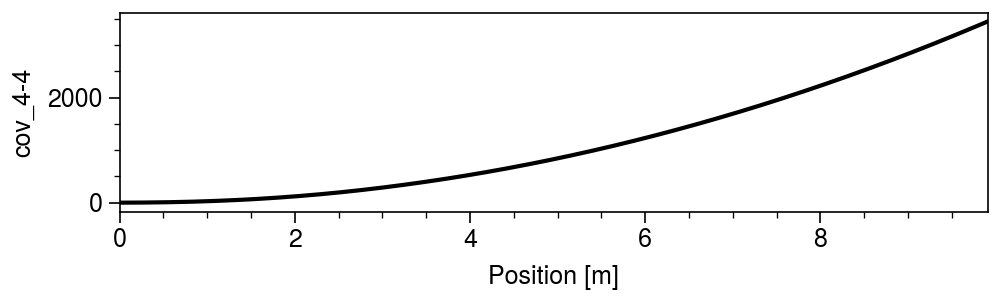

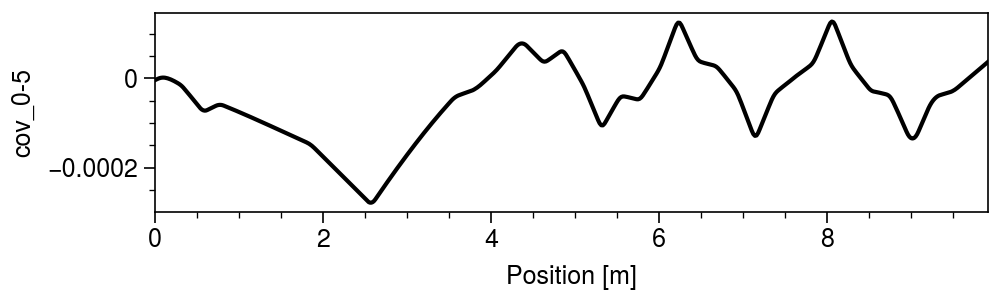

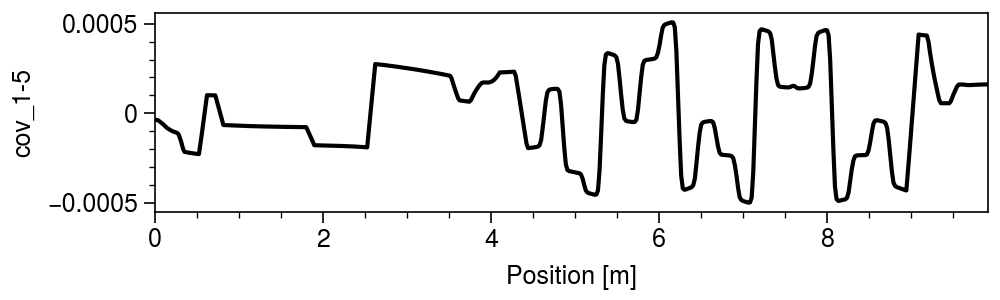

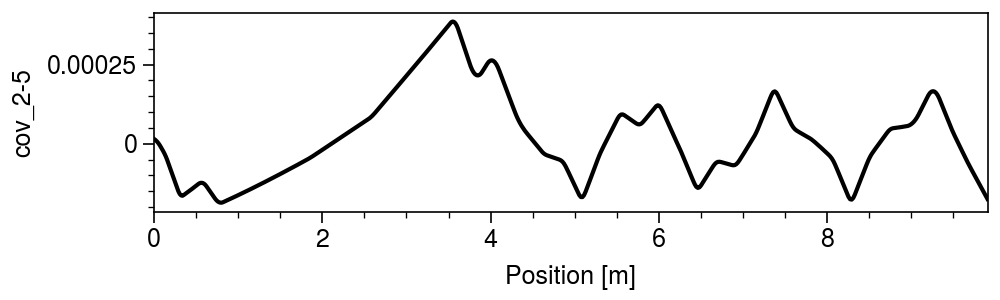

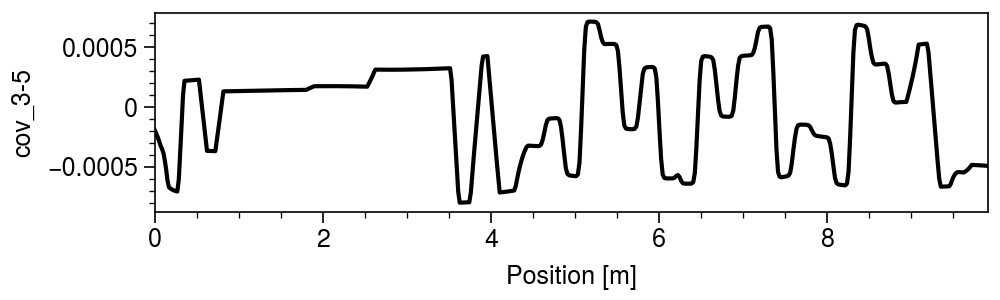

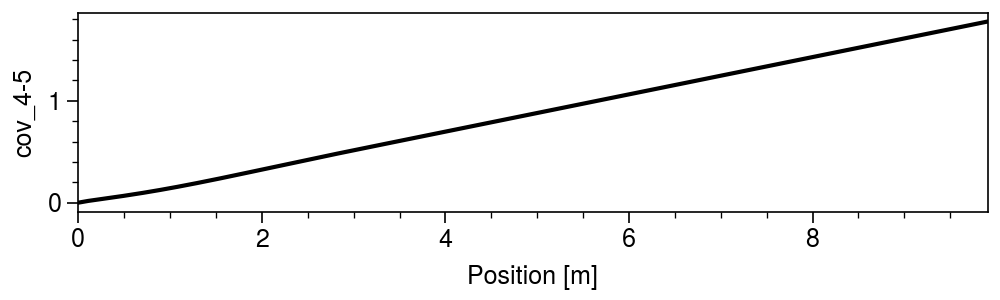

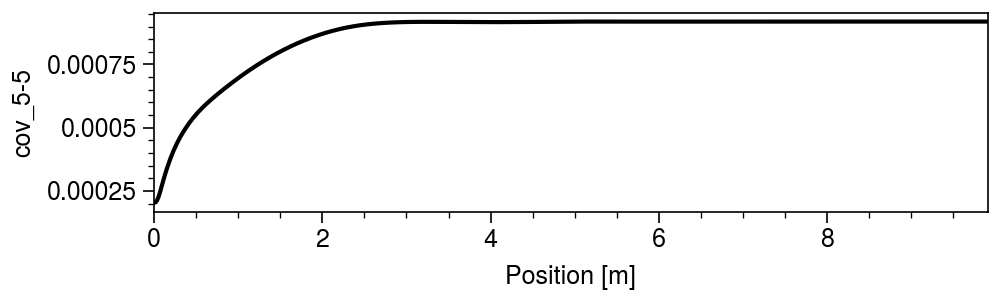

In [11]:
for i in range(6):
    for j in range(i + 1):
        fig, ax = pplt.subplots(figsize=(5.0, 1.5))
        ax.plot(
            history["position"],
            1.0e6 * history[f"cov_{j}-{i}"],
            color="black",
        )
        ax.format(xlabel="Position [m]")
        save_figure(f"cov_{j}-{i}")
        plt.show()

### Standard deviations

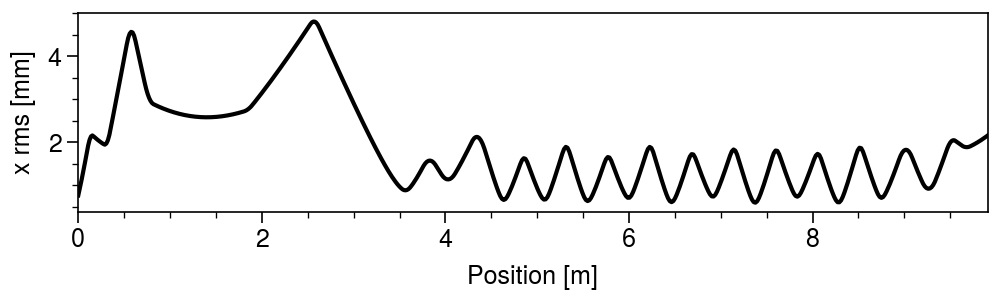

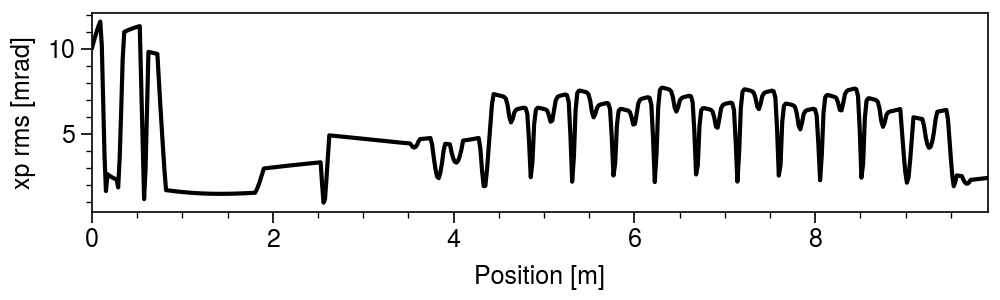

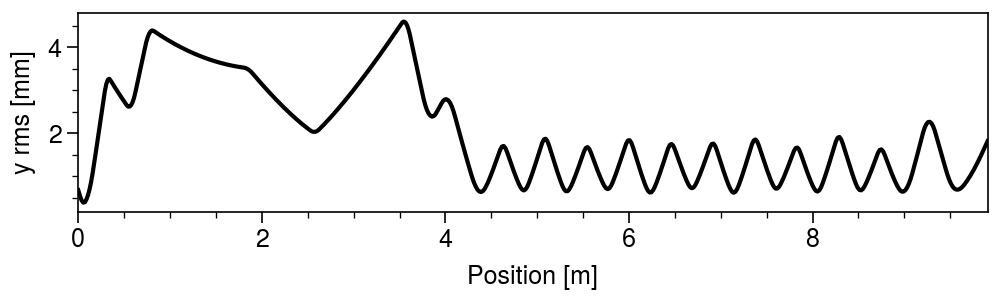

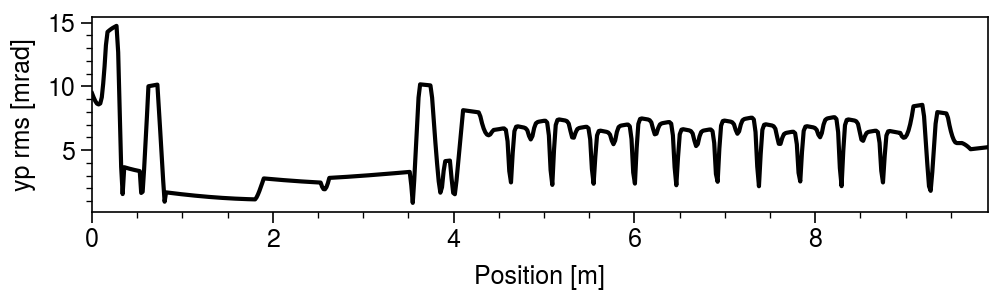

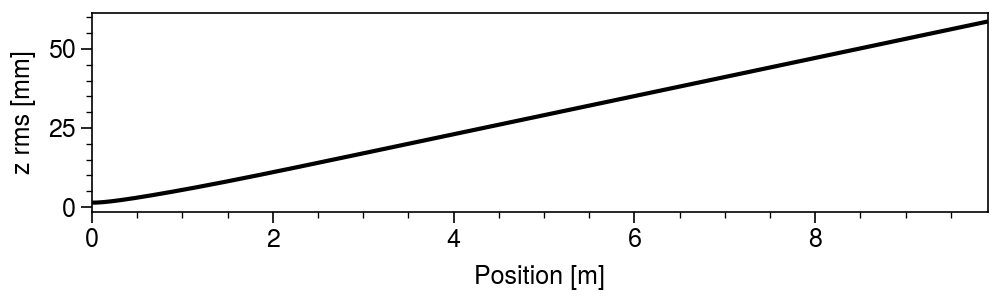

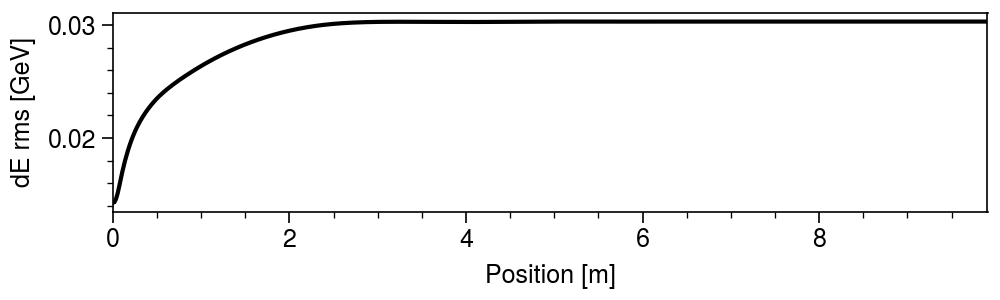

In [12]:
for i in range(6):
    fig, ax = pplt.subplots(figsize=(5.0, 1.5))
    ax.plot(
        history["position"],
        1.0e3 * np.sqrt(history[f"cov_{i}-{i}"]),
        color="black",
    )
    dims = ["x", "xp", "y", "yp", "z", "dE"]
    units = ["mm", "mrad", "mm", "mrad", "mm", "GeV"]
    ax.format(xlabel="Position [m]", ylabel=f"{dims[i]} rms [{units[i]}]")
    save_figure(f"rms_{i}")
    plt.show()

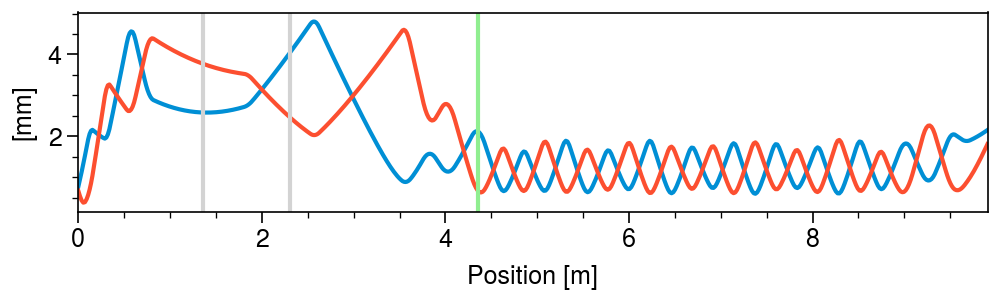

In [13]:
fig, ax = pplt.subplots(figsize=(5.0, 1.5))
for i, dim in enumerate("xy"):
    ax.plot(
        history["position"],
        1000.0 * history[f"{dim}_rms"],
        label=dim,
    )
    ax.format(xlabel="Position [m]", ylabel="[mm]")
ax.axvline(nodes_dict["MEBT:HZ04"][0], color="lightgray")
ax.axvline(nodes_dict["MEBT:HZ06"][0], color="lightgray")
ax.axvline(nodes_dict["MEBT:QH10"][0], color="lightgreen")
plt.show()

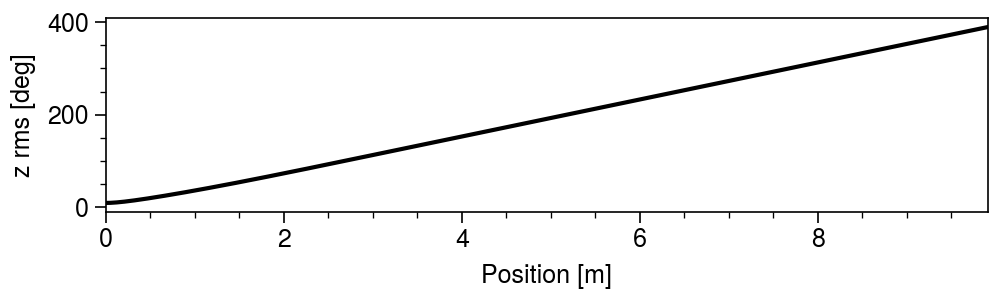

In [14]:
fig, ax = pplt.subplots(figsize=(5.0, 1.5))
ax.plot(
    history["position"],
    history["z_rms_deg"],
    color="black",
)
ax.format(xlabel="Position [m]", ylabel="z rms [deg]")
save_figure(f"rms_4_deg")
plt.show()

### Emittances 

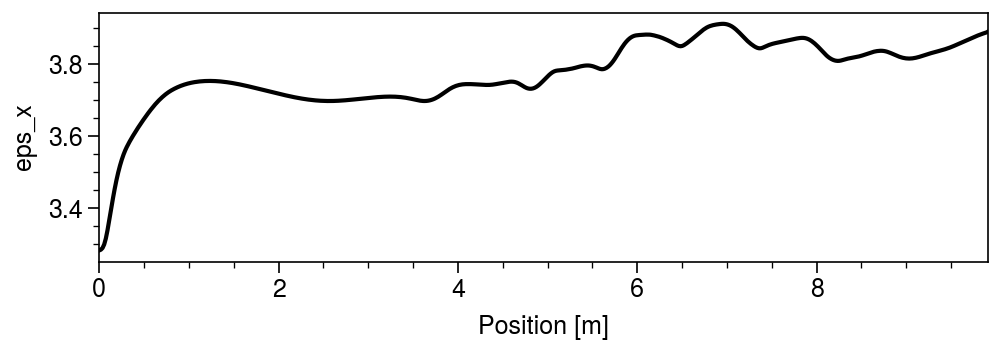

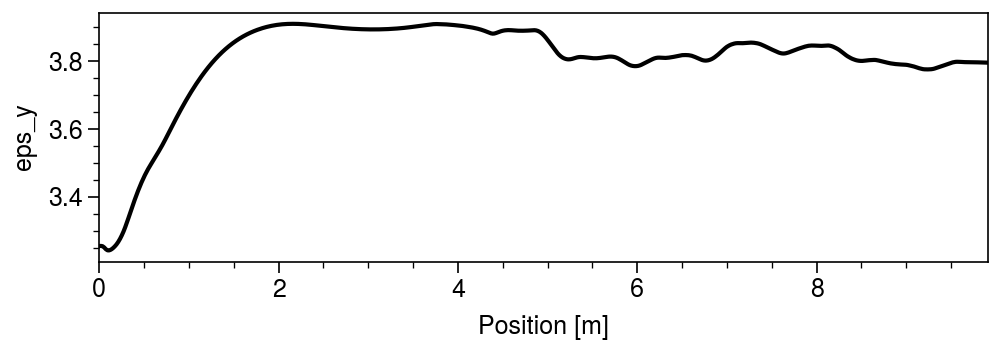

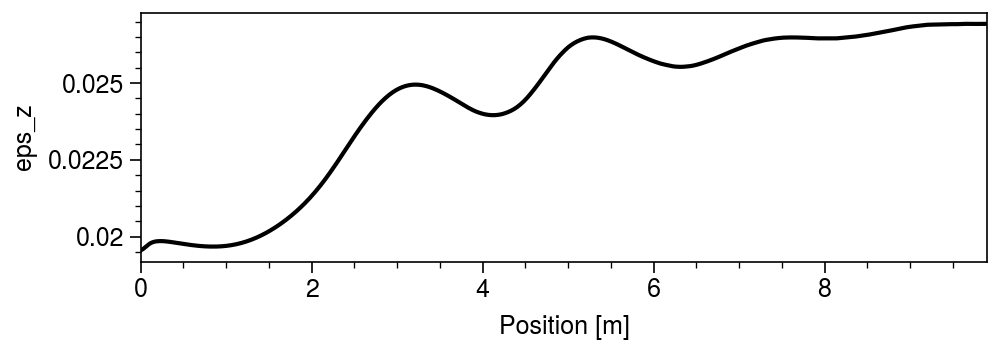

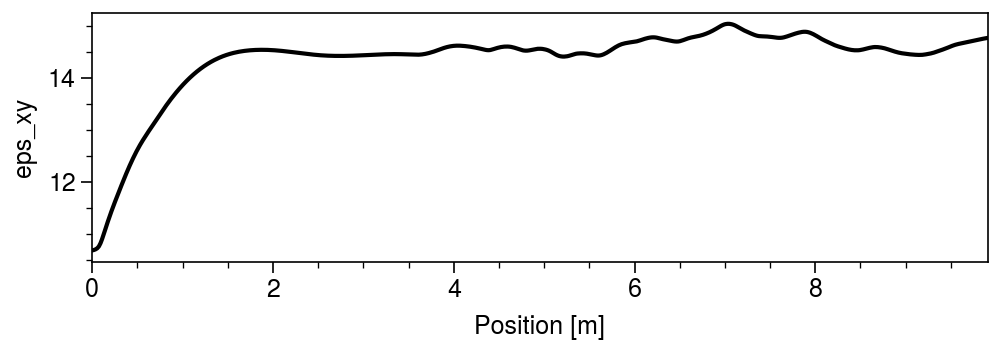

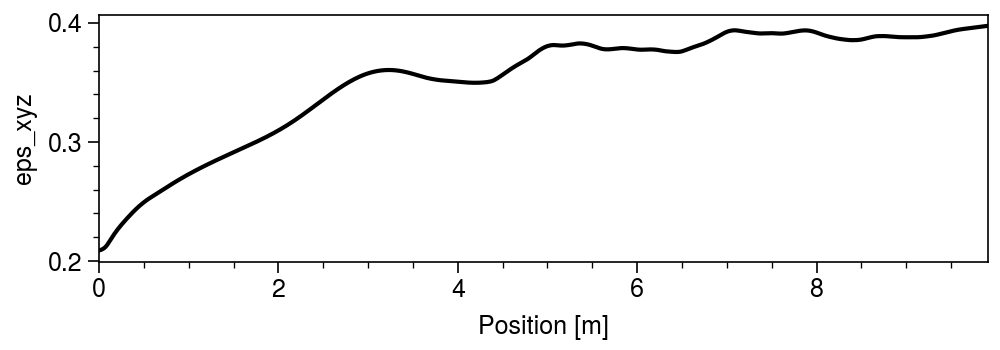

In [15]:
for tag in ["x", "y", "z", "xy", "xyz"]:
    factor = 1.0
    if tag in ["x", "y", "z"]:
        factor = 1.00e+06
    if tag == "xy":
        factor = 1.00e+12
    elif tag == "xyz":
        factor = 1.00e+18
        
    fig, ax = pplt.subplots(figsize=(5.0, 1.75))
    ax.plot(
        history["position"],
        factor * history[f"eps_{tag}"],
        color="black",
    )
    ax.format(xlabel="Position [m]", ylabel="eps_{}".format(tag))
    save_figure(f"eps_{tag}")
    plt.show()

### Extrema 

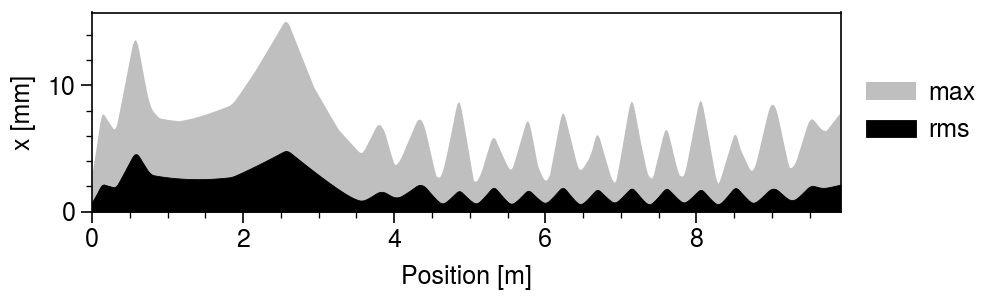

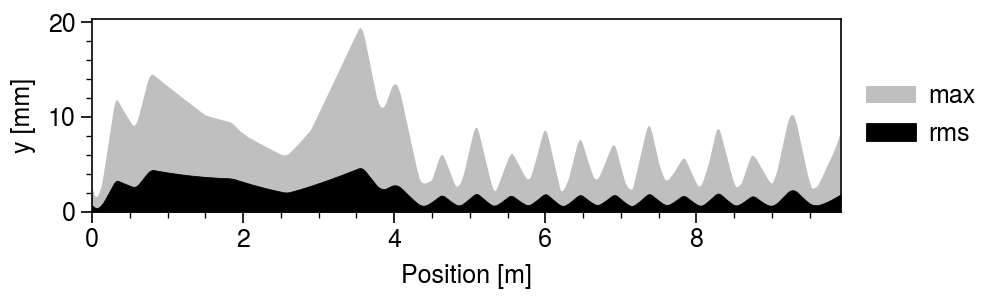

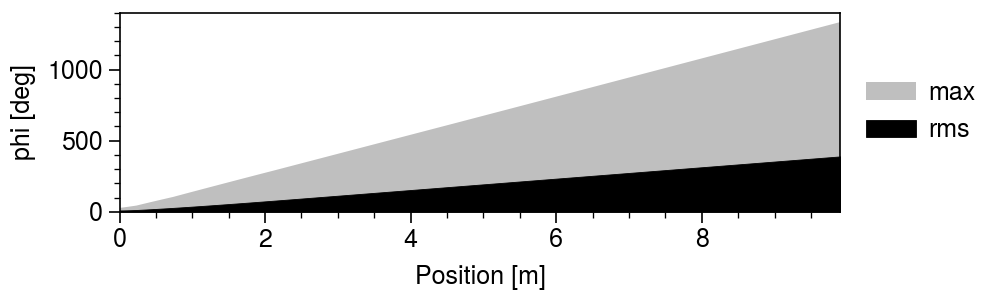

In [16]:
history["phi_rms"] = history["z_rms_deg"]

for dim, unit in zip(["x", "y", "phi"], ["mm", "mm", "deg"]):
    fig, ax = pplt.subplots(figsize=(5.0, 1.5))
    factor = 1.0
    if dim in "xy":
        factor = 1000.0
    ax.fill_between(
        history["position"],
        0.0,
        factor * history[f"{dim}_max"],
        color="black",
        alpha=0.25,
        ec="None",
        label="max",
    )
    ax.fill_between(
        history["position"],
        0.0,
        factor * history[f"{dim}_rms"],
        color="black",
        label="rms",
    )
    ax.legend(loc="r", ncols=1, framealpha=0.0)
    ax.format(xlabel="Position [m]", ylabel=f"{dim} [{unit}]")
    save_figure(f"extrema_rms_{dim}")
    plt.show()

## Phase space distribution 

### Load bunches

Collect bunch file names.

In [17]:
bunch_filenames = os.listdir(folder)
bunch_filenames = [f for f in bunch_filenames if "bunch" in f]
bunch_filenames = [f for f in bunch_filenames if "lostbunch" not in f]
bunch_filenames = [f for f in bunch_filenames if "smallbunch" not in f]
bunch_filenames = sorted(bunch_filenames)
bunch_filenames = [os.path.join(folder, f) for f in bunch_filenames]

n_frames = len(bunch_filenames)

pprint(bunch_filenames)

['../../data/sns_btf/sim/230905102530/bunch_0000_START.dat',
 '../../data/sns_btf/sim/230905102530/bunch_0001_MEBT:HZ33a.dat']


For each bunch, find its index in the history array. This tells us the position, node, energy, etc. for each bunch. We can then convert z to phi if we want.

In [18]:
bunch_history_indices = []
for frame, filename in enumerate(bunch_filenames):
    node = filename.split("bunch_")[-1].split(".dat")[0]
    node = node[(node.find("_") + 1):]
    if node == "START":
        index = 0
    elif node == "STOP":
        index = history.shape[0] - 1
    else:
        index = history["node"].tolist().index(node)
    bunch_history_indices.append(index)
    print(f"frame={frame}, node={node}, history_index={index}")

frame=0, node=START, history_index=0
frame=1, node=MEBT:HZ33a, history_index=535


Load the phase space coordinates.

In [19]:
bunches = []
columns = ["x", "xp", "y", "yp", "z", "w", "index", "x0", "xp0", "y0", "yp0", "z0", "w0"]
for frame, filename in enumerate(tqdm(bunch_filenames)):
    bunch = np.loadtxt(filename, comments="%", max_rows=None)
    # Convert [m, rad, m, rad, m, GeV] -> [mm, mrad, mm, mrad, mm, MeV]
    bunch[:, :6] *= 1.00e+03
    if bunch.shape[1] >= 13:
        bunch[:, 7:13] *= 1.00e+03
    # Create DataFrame.
    bunch = pd.DataFrame(bunch, columns=columns[:bunch.shape[1]])
    if "index" in bunch.columns:
        bunch["index"] = bunch["index"].astype(int)
    # Convert z --> phi.
    j = bunch_history_indices[frame]
    z_to_phase_coeff = history.loc[j, "z_to_phase_coeff"]
    bunch["phi"] = -z_to_phase_coeff * 0.001 * bunch["z"]
    if "z0" in bunch:
        bunch["phi0"] = -z_to_phase_coeff * 0.001 * bunch["z0"]
    bunches.append(bunch)

  0%|          | 0/2 [00:00<?, ?it/s]

### 1D projections

Decide on units.

In [20]:
use_phi = True
dims = ["x", "xp", "y", "yp", "z", "w"]
units = ["mm", "mrad", "mm", "mrad", "mm", "MeV"]
if use_phi:
    dims[4] = "phi"
    units[4] = "deg"
dims_units = [f"{dim} [{unit}]" for dim, unit in zip(dims, units)]

#### Partial projections [INT]

In [21]:
psv.cloud.proj1d_interactive_slice(
    data=[bunch.loc[:, dims].values for bunch in bunches],
    dims=dims,
    units=units,
    autolim_kws=dict(pad=0.1, zero_center=True, sigma=None, share=None),
    color="black",
)

interactive(children=(BoundedIntText(value=0, description='frame', max=1), Dropdown(description='dim', options…

#### Full projections

The following cell saves all 1D projections of the phase space distribution at each frame.

In [22]:
if save:
    bins = 85
    for frame, bunch in enumerate(tqdm(bunches)):
        X = bunch.loc[:, dims].values
        X_scaled = X / np.std(X, axis=0)
        limits = psv.cloud.auto_limits(X_scaled, pad=0.1, zero_center=True)
        for i in range(X.shape[1]):
            profile, edges = np.histogram(X_scaled[:, i], bins, limits[i])
            profile = profile / np.max(profile)
            fig, ax = pplt.subplots()
            psv.plot_profile(
                profile=profile,
                edges=edges,
                ax=ax,
                color="black",
                kind="step",
                lw=1.5,
            )
            ax.format(yscale="log", yformatter="log")
            ax.format(xlabel=r"{} / $\sigma$".format(dims[i]))
            save_figure(f"proj1d_{i}_{frame}")
            plt.close()

### 2D projections 

#### Partial projections [INT]

In [23]:
psv.cloud.proj2d_interactive_slice(
    data=[bunch.loc[:, dims].values for bunch in bunches],
    dims=dims,
    units=units,
    autolim_kws=dict(zero_center=True, sigma=None, share=None),
    options=dict(
        log=True,
        mask=True,
        normalize=True,
        ellipse=True,
        profiles=True,
    ),
    process_kws=dict(norm="max"),
    colorbar=True,
    colorbar_kw=dict(tickminor=True),
)

interactive(children=(BoundedIntText(value=0, description='frame', max=1), Dropdown(description='dim 1', optio…

#### Full projections (joint plot)

In [24]:
if save:
    bins = 85
    for frame, bunch in enumerate(tqdm(bunches)):
        X = ps.cloud.norm_xxp_yyp_zzp(
            bunch.loc[:, dims].values,
            scale_emittance=True,
        )
        limits = psv.cloud.auto_limits(X, pad=0.1, zero_center=True)
        for i in range(X.shape[1]):
            for j in range(i):
                axis = (j, i)
                grid = psv.JointGrid(
                    marg_kws=dict(space="2.0em", width="13.0em"),
                    marg_fmt_kws_x=dict(yspineloc="left", xspineloc="bottom"),
                    marg_fmt_kws_y=dict(yspineloc="left", xspineloc="bottom"),
                    xspineloc="bottom",
                    yspineloc="left",
                )
                grid.plot_cloud(
                    X[:, axis], 
                    kind="hist",
                    bins=bins,
                    limits=[limits[k] for k in axis],
                    marg_kws=dict(scale="max"),
                    marg_hist_kws=dict(bins=bins),
                    process_kws=dict(norm="max"),
                    offset=1.0,
                    norm="log",
                    colorbar=True,
                    colorbar_kw=dict(tickminor=True, width="1.2em"),
                )
                ymin = 10.0**-6.0
                ymax = 2.0
                grid.ax_marg_x.format(yformatter="log", yscale="log")
                grid.ax_marg_y.format(xformatter="log", xscale="log")
                grid.ax_marg_x.format(ymin=ymin, ymax=ymax)
                grid.ax_marg_y.format(xmin=ymin, xmax=ymax)
                grid.ax.format(xlabel=dims[axis[0]], ylabel=dims[axis[1]])
                save_figure(f"proj2d_{axis[0]}-{axis[1]}_{frame}")
                plt.close()

### Corner plots

In [25]:
if save:
    for i, bunch in enumerate(tqdm(bunches)):
        X = ps.cloud.norm_xxp_yyp_zzp(
            bunch.iloc[:, :6].values,
            scale_emittance=True,
        )
        grid = psv.CornerGrid(d=6, labels=dims, corner=True, diag_rspine=True, space=1.4)
        grid.plot_cloud(
            X, 
            lower=True, 
            upper=False,     
            autolim_kws=dict(pad=0.1, zero_center=True), 
            kind="hist",
            bins=100,
            offset=1.0,
            norm="log",
            cmap="viridis",
        )
        grid.format_diag(yscale="log", yformatter="log", ymin=(10.0 ** -6.0))
        save_figure(f"corner_log_{i}")
        plt.show()

### Radial density

Here we compute the density within spherical shells.

#### Interactive [INT]

In [26]:
@interact(
    frame=widgets.BoundedIntText(min=0, max=(len(bunches) - 1), value=0),
    bins=(25, 75),
    log=True,
    x=True,
    px=True,
    y=False,
    py=False,
    z=False,
    pz=False,
)
def update_radial_density(frame, bins, log, x, px, y, py, z, pz):
    bunch = bunches[frame]
    X = ps.cloud.norm_xxp_yyp_zzp(bunch.loc[:, dims].values, scale_emittance=True) 
    axis = tuple([i for i, check in enumerate([x, px, y, py, z, pz]) if check])

    fig, ax = pplt.subplots()
    hist_r, edges_r = ps.cloud.radial_histogram(X[:, axis], bins=bins, centers=False)
    hist_r = hist_r / np.sum(hist_r * np.diff(edges_r))
    centers_r = ps.utils.centers_from_edges(edges_r)
    ax.plot(centers_r, hist_r, drawstyle="steps-mid", color="black")
    ax.format(
        xmin=0.0,
        xlabel="radius", ylabel="density",
        title=f"axis={axis}", title_kw=dict(fontsize="medium"),
    )

    ymin = min(hist_r[hist_r > 0])
    ax.plot(centers_r, np.exp(-0.5 * (centers_r**2)), color="black", alpha=0.2)
    ax.format(ymin=ymin)

    if log:
        ax.format(yscale="log", yformatter="log")
    return ax

interactive(children=(BoundedIntText(value=0, description='frame', max=1), IntSlider(value=50, description='bi…

In [27]:
axis_list_all = []
for i in range(6):
    for j in range(i):
        axis_list_all.append((j, i))
        for k in range(j):
            axis_list_all.append((k, j, i))
            for l in range(k):
                axis_list_all.append((l, k, j, i))
                for m in range(l):
                    axis_list_all.append((m, l, k, j, i))
axis_list_all.append((0, 1, 2, 3, 4, 5))

In [28]:
axis_list = [
    (0, 1),
    (2, 3),
    (4, 5),
    (0, 1, 2, 3),
    (0, 1, 4, 5),
    (2, 3, 4, 5),
    (0, 1, 2, 3, 4, 5),
]

In [29]:
if save:
    for frame in tqdm(range(n_frames)):
        for axis in tqdm(axis_list):
            switches = 6 * [False]
            for k in axis:
                switches[k] = True
            x, xp, y, yp, z, pz = switches
            ax = update_radial_density(
                frame=frame,
                bins=50,
                log=True,
                x=switches[0],
                px=switches[1],
                y=switches[2],
                py=switches[3],
                z=switches[4],
                pz=switches[5],
            )
        
            _dims = [r"x", r"x'", "y", "y'", "z", "z'"]
            xlabel = "-".join([_dims[k] for k in axis])
            xlabel = f"Radius ({xlabel})"
            ax.format(yscale="log", yformatter="log", xlabel=xlabel, ylabel="Density", xmin=0.0)
            ax.legend(loc="upper right", ncols=1)
        
            tag = "-".join([str(k) for k in axis])
            save_figure(f"radial_{tag}_{frame}")
            plt.close()

## Losses

### Scalar

In [30]:
apertures = pd.read_csv(os.path.join(folder, f"losses.txt"), sep=" ")
apertures

,node,position,loss
0,MEBT1:START:1:drift:Aprt,0.000000,0.0
1,MEBT:QH01:AprtIn,0.100500,0.0
2,MEBT:QH01:AprtOut,0.161500,0.0
3,MEBT1:MEBT:QH01:1:drift:Aprt,0.161500,0.0
4,MEBT1:MEBT:QH01:12:drift:Aprt,0.271042,0.0
...,...,...,...
146,MEBT2:MEBT:DH1:1:drift:Aprt,11.550288,0.0
147,MEBT2:MEBT:DH1:12:drift:Aprt,11.658474,0.0
148,MEBT2:MEBT:DH1:23:drift:Aprt,11.766660,0.0
149,MEBT2:MEBT:VS34:8:drift:Aprt,11.872667,0.0


In [31]:
apertures["loss"].sum()

0.0

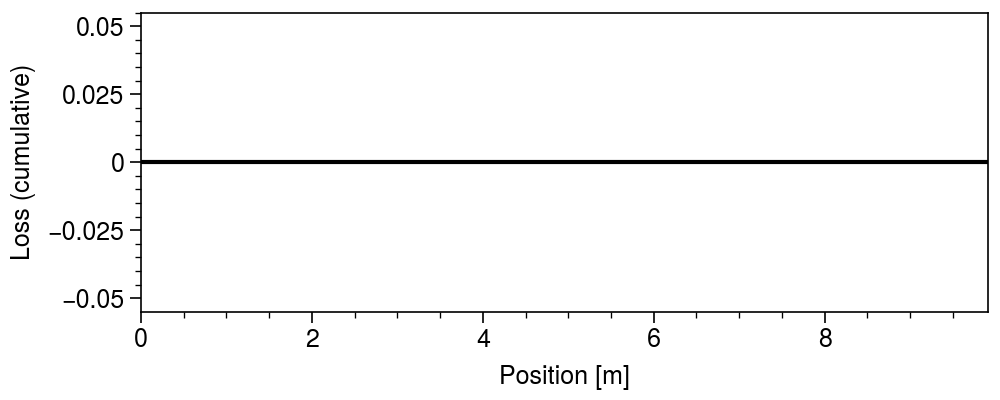

In [32]:
fig, ax = pplt.subplots(figsize=(5.0, 2.0))
ax.plot(
    history["position"],
    abs(history["n_parts"] - history.loc[0, "n_parts"]),
    color="black",
)
ax.format(xlabel="Position [m]", ylabel="Loss (cumulative)")
save_figure("loss_cumulative")
plt.show()

### Lost phase space distribution

Get lost bunch filename.

In [33]:
filenames = [f for f in os.listdir(folder) if "lostbunch" in f ]
filenames = [os.path.join(folder, f) for f in filenames]
filename = filenames[0]
filename

'../../data/sns_btf/sim/230905102530/lostbunch.dat'

Load lost bunch.

In [34]:
lostbunch = np.loadtxt(filename, comments="%")
lostbunch[:, :6] *= 1000.0    
lostbunch = pd.DataFrame(lostbunch, columns=["x", "xp", "y", "yp", "z", "dE", "s", "index"])
lostbunch["index"] = lostbunch["index"].astype(int)
lostbunch = lostbunch.sort_values("s")
z_to_phase_interp = interpolate.interp1d(
    history["position"], history["z_to_phase_coeff"], kind="linear"
)
lostbunch["phi"] = -z_to_phase_interp(lostbunch["s"]) * 0.001 * lostbunch["z"]
lostbunch

/tmp/ipykernel_1550485/742637109.py:1: UserWarning: loadtxt: input contained no data: "../../data/sns_btf/sim/230905102530/lostbunch.dat"
  lostbunch = np.loadtxt(filename, comments="%")


array([], dtype=float64)

#### Lost r-z coordinates

In [36]:
lostbunch["r"] = np.sqrt(lostbunch["x"]**2 + lostbunch["y"]**2)

fig, ax = pplt.subplots()
ax.hist2d(
    lostbunch["phi"], 
    lostbunch["r"], 
    bins=100,
    colorbar=True,
    colorbar_kw=dict(label="s [m]"),
)
ax.format(xlabel=r"phi [deg]", ylabel="radius [mm]")
save_figure("loss_rz")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices